# Data Cleaning/EDA

In [1]:
import pandas as pd
import numpy as np
from surprise import Reader, Dataset
from surprise import KNNBasic
from surprise import SVD
from surprise import accuracy
from surprise.model_selection import cross_validate, train_test_split
from surprise.prediction_algorithms import knns
from surprise.similarities import cosine, msd, pearson
from surprise import accuracy
from surprise.prediction_algorithms import SVD
from surprise.prediction_algorithms import NMF
from surprise.prediction_algorithms import SVDpp
from surprise import KNNBasic, KNNWithMeans, KNNWithZScore
from surprise.model_selection import GridSearchCV
from pyspark.sql import SparkSession
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def vanilla_model(data):
    
    
    knnbasic_cv = cross_validate(KNNBasic(), data, cv=5, n_jobs=-1, verbose=True)
    knnmeans_cv = cross_validate(KNNWithMeans(), data, cv=5, n_jobs=-1, verbose=True)
    knnz_cv = cross_validate(KNNWithZScore(), data, cv=5, n_jobs=-1, verbose=True)


    svd_cv = cross_validate(SVD(), data, cv=5, n_jobs=-1, verbose=True)
    svdpp_cv = cross_validate(SVDpp(), data, cv=5, n_jobs=-1, verbose=True)
    nmf_cv = cross_validate(NMF(), data, cv=5, n_jobs=-1, verbose=True)

In [3]:
ratings_df = pd.read_csv('ratings.csv')
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [4]:
ratings_df.shape

(100836, 4)

In [5]:
ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [6]:
ratings_df.isna().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

In [7]:
ratings_df.describe()

,userId,movieId,rating,timestamp
count,100836.000000,100836.000000,100836.000000,1.008360e+05
mean,326.127564,19435.295718,3.501557,1.205946e+09
std,182.618491,35530.987199,1.042529,2.162610e+08
min,1.000000,1.000000,0.500000,8.281246e+08
25%,177.000000,1199.000000,3.000000,1.019124e+09
50%,325.000000,2991.000000,3.500000,1.186087e+09
75%,477.000000,8122.000000,4.000000,1.435994e+09
max,610.000000,193609.000000,5.000000,1.537799e+09


In [8]:
ratings_df['rating'].value_counts()

4.0    26818
3.0    20047
5.0    13211
3.5    13136
4.5     8551
2.0     7551
2.5     5550
1.0     2811
1.5     1791
0.5     1370
Name: rating, dtype: int64

In [9]:
new_ratings_df = ratings_df.drop(columns='timestamp')

In [10]:
new_ratings_df.nunique()

userId      610
movieId    9724
rating       10
dtype: int64

### Histogram of the number of users per rating

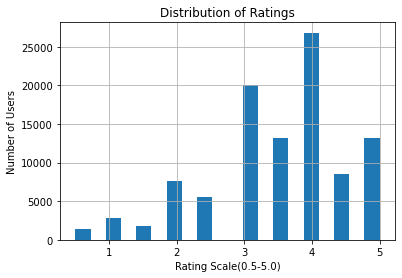

In [11]:
new_ratings_df['rating'].hist(bins=20)

plt.title('Distribution of Ratings')
  
plt.xlabel('Rating Scale(0.5-5.0)')
plt.ylabel('Number of Users');

As the graph aboves illustrates, on a scale of 0.5-5.0, most users rated movies they watched 3.0 or 4.0.

# Collaborative Filtering

In [12]:
reader = Reader(rating_scale=(0.5,5))
data = Dataset.load_from_df(new_ratings_df,reader)

In [13]:
train, test = train_test_split(data, test_size=.2)

In [14]:
vanilla_model(data)

Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9341  0.9473  0.9574  0.9440  0.9555  0.9476  0.0084  
MAE (testset)     0.7152  0.7280  0.7333  0.7236  0.7320  0.7264  0.0066  
Fit time          0.07    0.05    0.06    0.08    0.07    0.06    0.01    
Test time         1.10    1.07    1.10    1.04    1.04    1.07    0.03    
Evaluating RMSE, MAE of algorithm KNNWithMeans on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8902  0.9009  0.9000  0.8973  0.8989  0.8975  0.0038  
MAE (testset)     0.6798  0.6888  0.6872  0.6886  0.6843  0.6858  0.0034  
Fit time          0.08    0.08    0.07    0.07    0.06    0.07    0.01    
Test time         1.21    1.17    1.21    1.20    1.19    1.19    0.02    
Evaluating RMSE, MAE of algorithm KNNWithZScore on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean  

In [15]:
def run_model(model):
    
    model.fit(train)
    predictions = model.test(test)
    acc = accuracy.rmse(predictions)

    return model

In [16]:
svd_model = SVD()

run_model(svd_model)

RMSE: 0.8635


In [17]:
svdpp_model = SVDpp()

run_model(svdpp_model)

RMSE: 0.8513


# Hyperparameter Tuning using GridSearch

In [18]:
data = Dataset.load_from_df(new_ratings_df, reader)

param_grid = {'n_epochs': [5, 10], 'lr_all': [0.002, 0.005],
              'reg_all': [0.4, 0.6]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)

gs.fit(data)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.8945156391424312
{'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.4}


In [19]:
data = Dataset.load_from_df(new_ratings_df, reader)

param_grid = {'n_epochs': [5, 10], 'lr_all': [0.002, 0.005],
              'reg_all': [0.4, 0.6]}
gs = GridSearchCV(SVDpp, param_grid, measures=['rmse', 'mae'], cv=3)

gs.fit(data)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.8937402225278653
{'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.4}


Based on the results of the GridSearch tuning, the SVD model performed slightly better than the SVDpp. I ran another GridSearch tuning of the SVD model, modifying the number of epochs, learning rate and regularization, while also including n_factors into the tuning process:

In [20]:
data = Dataset.load_from_df(new_ratings_df, reader)

param_grid = {'n_epochs': [10, 25, 50], 'lr_all': [0.02, 0.0005, 0.001],
              'reg_all': [0.01, 0.06, 0.1, 0.5], 'n_factors': [50, 100, 150]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)

gs.fit(data)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.858522631721935
{'n_epochs': 50, 'lr_all': 0.02, 'reg_all': 0.1, 'n_factors': 150}


In [21]:
results_df = pd.DataFrame.from_dict(gs.cv_results)

In [22]:
results_df.head()

,split0_test_rmse,split1_test_rmse,split2_test_rmse,mean_test_rmse,std_test_rmse,rank_test_rmse,split0_test_mae,split1_test_mae,split2_test_mae,mean_test_mae,...,rank_test_mae,mean_fit_time,std_fit_time,mean_test_time,std_test_time,params,param_n_epochs,param_lr_all,param_reg_all,param_n_factors
0,0.903288,0.902083,0.901517,0.902296,0.000738,61,0.692980,0.694914,0.694010,0.693968,...,46,0.939196,0.006393,0.173309,0.031385,"{'n_epochs': 10, 'lr_all': 0.02, 'reg_all': 0....",10,0.02,0.01,50
1,0.900908,0.900703,0.900031,0.900547,0.000375,58,0.693749,0.693503,0.693870,0.693707,...,43,1.552515,0.005345,0.169537,0.026325,"{'n_epochs': 10, 'lr_all': 0.02, 'reg_all': 0....",10,0.02,0.01,100
2,0.902712,0.902063,0.902601,0.902459,0.000283,62,0.696479,0.695048,0.696288,0.695938,...,58,2.168243,0.007033,0.173924,0.023646,"{'n_epochs': 10, 'lr_all': 0.02, 'reg_all': 0....",10,0.02,0.01,150
3,0.870907,0.867214,0.867050,0.868390,0.001781,13,0.669336,0.668301,0.666302,0.667979,...,13,0.925543,0.004698,0.148443,0.028087,"{'n_epochs': 10, 'lr_all': 0.02, 'reg_all': 0....",10,0.02,0.06,50
4,0.867821,0.869030,0.867267,0.868040,0.000736,12,0.666144,0.669479,0.666911,0.667511,...,11,1.552279,0.002709,0.168986,0.026853,"{'n_epochs': 10, 'lr_all': 0.02, 'reg_all': 0....",10,0.02,0.06,100


# Final Model

I used SVD as my final model. I created a residual plot to show the actual ratings compared to the predictive ratings:

In [23]:
def predict_rating(row):
    return svd_model.predict(row['userId'], row['movieId'])[3]

In [24]:
new_ratings_df['predicted_rating'] = new_ratings_df.apply(predict_rating, axis=1)
new_ratings_df.head()

,userId,movieId,rating,predicted_rating
0,1,1,4.0,4.544685
1,1,3,4.0,4.013875
2,1,6,4.0,4.715126
3,1,47,5.0,4.953556
4,1,50,5.0,5.000000


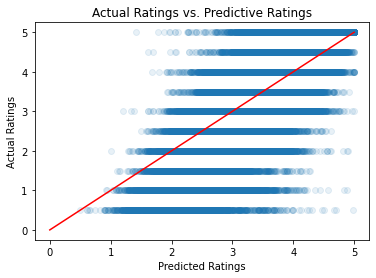

In [25]:
plt.scatter(new_ratings_df['predicted_rating'], new_ratings_df['rating'], alpha=0.1)
plt.plot([0, 5], [0, 5], color='red', linestyle='-')
plt.title('Actual Ratings vs. Predictive Ratings')
plt.xlabel('Predicted Ratings')
plt.ylabel('Actual Ratings')
plt.show()

The scatter plot above shows ratings of 3, 4, and 5 were underpredicted, while ratings ratings of 1 and 2 were overpredicted. This illustrates how this recommendation system model may recommend movies that users gave a low rating (1 and 2), and not recommend movies that were highly-rated by users (4 and 5). 

Text(0, 0.5, 'Number of Users')

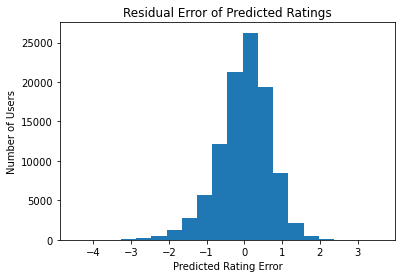

In [26]:
plt.hist(new_ratings_df['rating'] - new_ratings_df['predicted_rating'], bins=20)
plt.title('Residual Error of Predicted Ratings')
plt.xlabel('Predicted Rating Error')
plt.ylabel('Number of Users')

As the plot above shows, the residual error of predicted ratings was between 1 and -1.

# Predicting Ratings of New Users

In [27]:
svd_model.predict(4, 28)

Prediction(uid=4, iid=28, r_ui=None, est=3.2591703962027037, details={'was_impossible': False})

In [28]:
movies_df = pd.read_csv('movies.csv')
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [29]:
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


In [30]:
movies_df.isna().sum()

movieId    0
title      0
genres     0
dtype: int64

In [31]:
movies_df.nunique()

movieId    9742
title      9737
genres      951
dtype: int64

In [32]:
def movie_rater(movies_df,num, genre=None):
    userID = 1000
    rating_list = []
    while num > 0:
        if genre:
            movie = movies_df[movies_df['genres'].str.contains(genre)].sample(1)
        else:
            movie = movies_df.sample(1)
        print(movie)
        rating = input('How do you rate this movie on a scale of 1-5, press n if you have not seen :\n')
        if rating == 'n':
            continue
        else:
            rating_one_movie = {'userId':userID,'movieId':movie['movieId'].values[0],'rating':rating}
            rating_list.append(rating_one_movie) 
            num -= 1
    return rating_list

In [33]:
user_rating = movie_rater(movies_df, 4, 'Comedy')

      movieId                                 title  \
7887    94833  Pirates! Band of Misfits, The (2012)   

                                   genres  
7887  Adventure|Animation|Children|Comedy  
How do you rate this movie on a scale of 1-5, press n if you have not seen :
4
      movieId               title  genres
1973     2618  Castle, The (1997)  Comedy
How do you rate this movie on a scale of 1-5, press n if you have not seen :
3
      movieId                title        genres
7802    92259  Intouchables (2011)  Comedy|Drama
How do you rate this movie on a scale of 1-5, press n if you have not seen :
2
      movieId                title                         genres
3526     4818  Extreme Days (2001)  Action|Adventure|Comedy|Drama
How do you rate this movie on a scale of 1-5, press n if you have not seen :
5


### Adding New Ratings to Original ratings DataFrame

In [34]:
movie_ratings_df = new_ratings_df.append(user_rating,ignore_index=True)
new_data = Dataset.load_from_df(movie_ratings_df[['userId', 'movieId', 'rating']], reader)

### Train Model Using Combined DataFrame

In [35]:
svd_ = SVD(n_epochs=50, lr_all=0.02, reg_all=0.1, n_factors=150)
svd_.fit(new_data.build_full_trainset())

### Making Predictions for New User

In [36]:
list_of_movies = []
for m_id in movies_df['movieId'].unique():
    list_of_movies.append( (m_id,svd_.predict(1000,m_id)[3]))

In [37]:
ranked_movies = sorted(list_of_movies, key=lambda x:x[1], reverse=True)

In [38]:
predicted_movie_ratings = pd.DataFrame(list(ranked_movies), columns=['movieId', 'movie_rating'])
predicted_movie_ratings.head()

,movieId,movie_rating
0,4818,4.785441
1,78836,4.590417
2,27156,4.555696
3,152105,4.536162
4,33649,4.461334


In [39]:
def recommended_movies(user_ratings,movie_title_df,n):
        for idx, rec in enumerate(user_ratings):
            title = movie_title_df.loc[movie_title_df['movieId'] == int(rec[0])]['title']
            print('Recommendation # ', idx+1, ': ', title, '\n')
            n-= 1
            if n == 0:
                break
            
recommended_movies(ranked_movies,movies_df,5)

Recommendation #  1 :  3526    Extreme Days (2001)
Name: title, dtype: object 

Recommendation #  2 :  7364    Enter the Void (2009)
Name: title, dtype: object 

Recommendation #  3 :  5621    Neon Genesis Evangelion: The End of Evangelion...
Name: title, dtype: object 

Recommendation #  4 :  9227    Dad's Army (1971)
Name: title, dtype: object 

Recommendation #  5 :  5906    Saving Face (2004)
Name: title, dtype: object 



# Highest Ratings Based on Movie Genre

I used the recommendation system that was created on the movies dataset below:

In [40]:
movies_df['genres'].value_counts()

Drama                                              1053
Comedy                                              946
Comedy|Drama                                        435
Comedy|Romance                                      363
Drama|Romance                                       349
                                                   ... 
Action|Adventure|Crime|Drama|Thriller|War             1
Comedy|Crime|Drama|War                                1
Action|Adventure|Animation|Drama|Fantasy|Sci-Fi       1
Animation|Drama|War                                   1
Action|Crime|Film-Noir                                1
Name: genres, Length: 951, dtype: int64

In [41]:
movies_df=movies_df.assign(genres=movies_df.genres.str.split('|')).explode('genres')
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure
0,1,Toy Story (1995),Animation
0,1,Toy Story (1995),Children
0,1,Toy Story (1995),Comedy
0,1,Toy Story (1995),Fantasy


In [42]:
merged_movies_df = movies_df.set_index('movieId').join(predicted_movie_ratings.set_index('movieId'))

In [43]:
merged_movies_df = merged_movies_df.groupby('genres').mean().sort_values(by='movie_rating', ascending=False)

In [44]:
merged_movies_df = merged_movies_df.reset_index()

In [45]:
merged_movies_df.head()

,genres,movie_rating
0,Documentary,3.529600
1,Film-Noir,3.526166
2,War,3.396768
3,(no genres listed),3.381715
4,Animation,3.359243


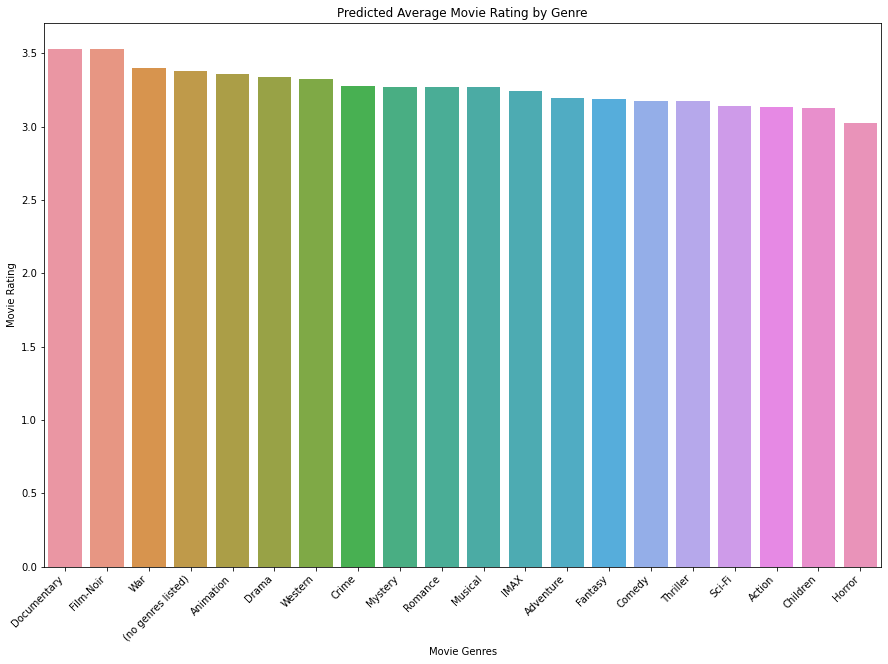

In [46]:
fig,ax = plt.subplots(figsize=(15,10))
sns.barplot(x = 'genres', y = 'movie_rating', data=merged_movies_df)
plt.xticks(rotation=45)

plt.setp(ax.xaxis.get_majorticklabels(), ha='right')
plt.title('Predicted Average Movie Rating by Genre')
plt.xlabel('Movie Genres')
plt.ylabel('Movie Rating');

The image above is a bar plot showing the predicted ratings of 1 user based on movie genre. As the image illustrates, Documentary and Film-Noir were the highest-rated genres for this particular user. These two genres are not traditionally among the most popular genres among users, and could indicate that popularity bias is mitigated in this recommendation system model. 

In [50]:
movie_ratings_df = movies_df.set_index('movieId').join(new_ratings_df.set_index('movieId'))
movie_ratings_df

,title,genres,userId,rating,predicted_rating
movieId,,,,,
1,Toy Story (1995),Adventure,1.0,4.0,4.544685
1,Toy Story (1995),Adventure,5.0,4.0,3.711521
1,Toy Story (1995),Adventure,7.0,4.5,3.589882
1,Toy Story (1995),Adventure,15.0,2.5,3.399324
1,Toy Story (1995),Adventure,17.0,4.5,4.050214
...,...,...,...,...,...
193583,No Game No Life: Zero (2017),Fantasy,184.0,3.5,3.744237
193585,Flint (2017),Drama,184.0,3.5,3.450685
193587,Bungo Stray Dogs: Dead Apple (2018),Action,184.0,3.5,3.712265


In [51]:
movie_ratings_df = movie_ratings_df.groupby('genres').mean().sort_values(by='rating', ascending=False)
movie_ratings_df.head()

,userId,rating,predicted_rating
genres,,,
Film-Noir,328.211494,3.920115,3.844649
War,316.816629,3.808294,3.775187
Documentary,341.381460,3.797785,3.588304
Crime,320.062406,3.658294,3.646192
Drama,326.857995,3.656184,3.626016


In [52]:
movie_ratings_df = movie_ratings_df.reset_index()
movie_ratings_df.head()

,genres,userId,rating,predicted_rating
0,Film-Noir,328.211494,3.920115,3.844649
1,War,316.816629,3.808294,3.775187
2,Documentary,341.381460,3.797785,3.588304
3,Crime,320.062406,3.658294,3.646192
4,Drama,326.857995,3.656184,3.626016


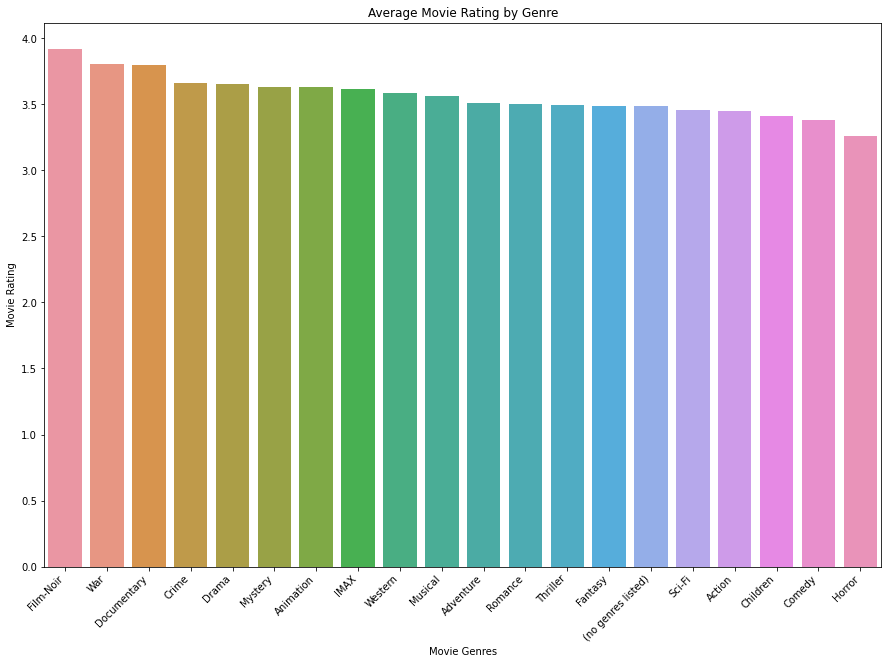

In [53]:
fig,ax = plt.subplots(figsize=(15,10))
sns.barplot(x = 'genres', y = 'rating', data=movie_ratings_df)
plt.xticks(rotation=45)

plt.setp(ax.xaxis.get_majorticklabels(), ha='right')
plt.title('Average Movie Rating by Genre')
plt.xlabel('Movie Genres')
plt.ylabel('Movie Rating');

# Popularity Bias

* Popular items that are overly exposed in recommendations at the expense of less popular items that users may find interesting.
* Hurts both users and items; users worse off-system only learns biased view of their true preferences.
* Popular does not equal better.
* Less popular items lose deserved feedback(clicks/views) + economic gains.

**Source: http://people.tamu.edu/~zhaoxing623/publications/Ziwei_KDD_2021.pdf

# Factors Impacting Popularity Bias

* Audience Size Imbalance, Model Bias, Position Bias, Closed Feedback Loop.
* Audience Size Imbalance: inherent imbalance-few items have large audience size, majority have small audience size; results in imbalance engagement data (clicks), even if every item is equally recommended.
* Model Bias: rank item with more clicks/views in training data higher than item with fewer clicks/views, even if user equally likes both items.
* Position Bias: probability to examine items at top ranking positions is higher than at lower positions; matched popular item being recommended and ranked at a top position is more likely to receive click/view than a matched but unpopular item also being recommended but ranked in lower position.
* Closed Feedback Loop: popularity bias generated in past accumulates, producing more bias in future models. **Source: http://people.tamu.edu/~zhaoxing623/publications/Ziwei_KDD_2021.pdf

# Final Conclusions

* SVD - best performing recommendation system model.
* Predicted ratings error between 1 and -1.
* Predicted ratings for one user based on movie genre-may help mitigate popularity bias.

# Next Steps

* Look beyond movies - include television shows.
* Compare movie ratings with television ratings.
* Include other features that may determine what impacts user ratings, i.e. actors, actresses, directors, etc.
* Data on features of users (i.e. Age, Gender) and examine any trends related to what ratings users gave movies/television shows.
* Consider user behavior since beginning of COVID-19 pandemic.
* Explore popularity bias in future models.